# HW 1-2: Optimization
## CPSC 8430
## Adam Patyk

In [1]:
import numpy as np
import torch

### Part 1: Visualize the Optimization Process

In [29]:
from torch.utils.data import DataLoader
from common.FunctionDataset import FunctionDataset

## -------------------------
## Prepare data for training
## -------------------------

num_data_points = 100
range_min = 0
range_max = 1

# create data points from function e^x * sin^2(3*pi*x) over a range
raw_data = FunctionDataset(num_data_points, range_min, range_max)

# z-score standardize training data
training_data = raw_data.standardize()

# create data loader for training
training_loader = DataLoader(training_data, batch_size=1, shuffle=True)

print('Data ready.')

Data ready.


In [92]:
from common.DNN_Models import ModerateNetwork

## --------------------------------------------------
## Train model multiple times logging loss and weights
## ---------------------------------------------------

# helper function to get flattened weights of a sequential model
def get_fc_weights(model):
  all_weights = np.zeros((1,0))
  layer_weights = np.zeros((1,0))
  for name, param in model.named_parameters():
    if 'weight' in name:
      # flatten all weights to 1D arrays 
      all_weights = np.concatenate((all_weights, param.data.view(1, -1).numpy()), axis=None)
      if 'fc2' in name:
        # save flattened weights from FC2 layer
        layer_weights = np.concatenate((layer_weights, param.data.view(1, -1).numpy()), axis=None)
  return layer_weights, all_weights

epochs = 90
num_training_times = 8
num_layers = 4

overall_loss = []
overall_weights = []
single_layer_weights = []

for i in range(num_training_times):
  # reset model between training
  DNN_Model = ModerateNetwork()
  DNN_Model.zero_grad()

  print(f'Training model - {i+1}')
  for epoch in range(epochs):
    # train
    loss = DNN_Model.train(training_loader)
    single_layer_w, all_w = get_fc_weights(DNN_Model)
    # log loss and weights every 3 epochs
    if epoch % 3 == 0: 
      overall_loss.append(loss)
      overall_weights.append(all_w)
      single_layer_weights.append(single_layer_w)

  print(f'Done. Loss: {loss:.6f}')

Training model - 1
Done. Loss: 1.078062
Training model - 2
Done. Loss: 0.694698
Training model - 3
Done. Loss: 0.131222
Training model - 4
Done. Loss: 0.818672
Training model - 5
Done. Loss: 0.512265
Training model - 6
Done. Loss: 1.114933
Training model - 7
Done. Loss: 0.373202
Training model - 8
Done. Loss: 0.728917


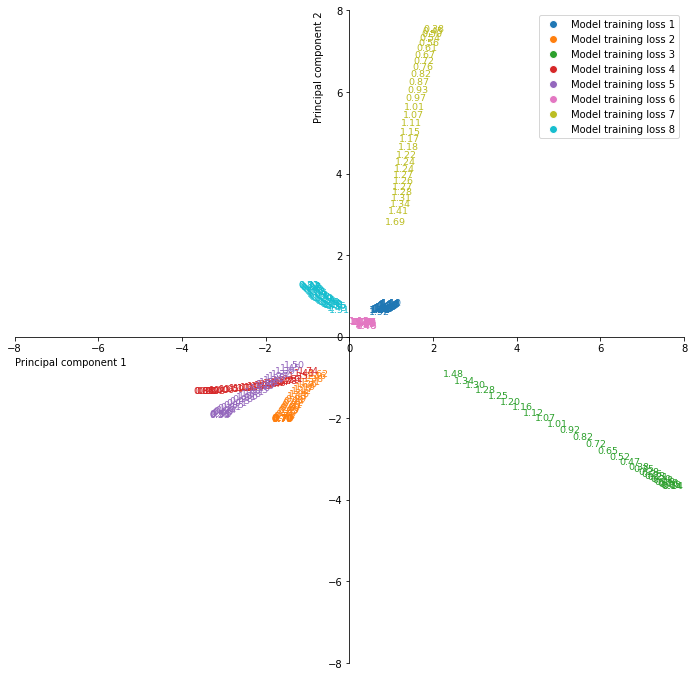

In [101]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## ------------------------------------------
## Plot PCA results to visualize optimization
## ------------------------------------------

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink', 'tab:olive', 'tab:cyan']
legend_elements =[]
for i in range(len(colors)):
    legend_elements.append(Line2D([0], [0], marker='o', color='w', 
            label=f'Model training loss {i+1}', markerfacecolor=colors[i], markersize=8))

segment_length = epochs // 3
training_segments = segment_length * num_training_times
pca = PCA(n_components=2)

# PCA on weights of entire model
principalComponents = pca.fit_transform(overall_weights)

fig = plt.figure(figsize=(12,12))
plt.axis([-8, 8, -8, 8])

for segment in range(num_training_times):
    start_idx = segment * segment_length
    end_idx = (segment+1) * segment_length
    for i in range(start_idx, end_idx):
        plt.text(principalComponents[i, 0],
                principalComponents[i, 1],
                '%.2f' % overall_loss[i],
                fontdict={'size': 9.5},
                color=colors[segment])
ax = plt.gca()
ax.legend(handles=legend_elements)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.xlabel('Principal component 1', loc='left')
plt.ylabel('Principal component 2', loc='top')
plt.savefig('results/2/fig_entire_model_pca.pdf')
plt.show()

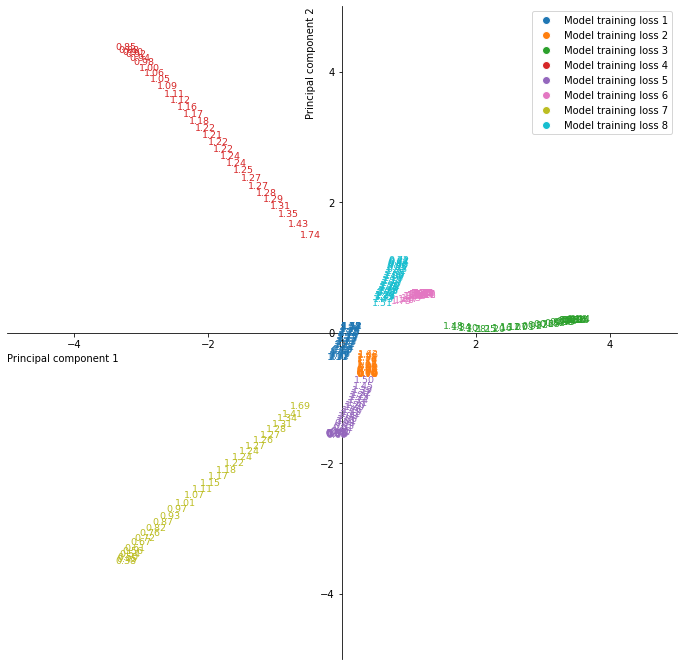

In [102]:
# PCA on weights of single layer (FC2)
principalComponents = pca.fit_transform(single_layer_weights)

fig = plt.figure(figsize=(12,12))
plt.axis([-5, 5, -5, 5])

for segment in range(num_training_times):
    start_idx = segment * segment_length
    end_idx = (segment+1) * segment_length
    for i in range(start_idx, end_idx):
        plt.text(principalComponents[i, 0],
                principalComponents[i, 1],
                '%.2f' % overall_loss[i],
                fontdict={'size': 9.5},
                color=colors[segment])
ax = plt.gca()
ax.legend(handles=legend_elements)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.xlabel('Principal component 1', loc='left')
plt.ylabel('Principal component 2', loc='top')
plt.savefig('results/2/fig_single_layer_pca.pdf')
plt.show()

### Part 2: Observe Gradient Norm During Training

In [3]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from common.FunctionDataset import FunctionDataset

## -------------------------
## Prepare data for training
## -------------------------

num_data_points = 100
range_min = 0
range_max = 1
img_batch_size = 32

# prepare data for e^x * sin^2(3*pi*x) function 
raw_func_data = FunctionDataset(num_data_points, range_min, range_max)
func_training_data = raw_func_data.standardize()
func_training_loader = DataLoader(func_training_data, batch_size=1, shuffle=True)

# prepare data for MNIST
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
mnist_training_set = torchvision.datasets.MNIST(root='./data/', train=True, 
                                          download=True, transform=transform)
mnist_training_loader = torch.utils.data.DataLoader(mnist_training_set, 
                                          batch_size=img_batch_size,
                                          shuffle=True)

print('Data ready.')

Data ready.


In [9]:
from common.DNN_Models import ModerateNetwork
from common.MNIST_CNN_Models import ModerateCNN

## --------------------------------
## Train models [est. time: 30 min] 
## --------------------------------

# helper function to calculate the gradient normal (p-norm, p=2)
def calc_grad_norm(model):
  grad_all = 0.0

  for p in model.parameters():
    grad = 0.0 
    if p.grad is not None:
      grad = (p.grad.cpu().data.numpy() ** 2).sum()
    grad_all += grad

  grad_norm = grad_all ** 0.5

  return grad_norm

DNN_epochs = 10000
CNN_epochs = 100

DNN_model = ModerateNetwork()
CNN_model = ModerateCNN()

DNN_model.zero_grad()
CNN_model.zero_grad()

overall_grad_norm = []
overall_loss = []

# train both models logging gradient norm and loss 
# DNN model
model_loss = []
model_grad_norm = []
print('Training DNN model:')
for epoch in range(DNN_epochs):
    loss = DNN_model.train(func_training_loader)
    grad_norm = calc_grad_norm(DNN_model)
    model_loss.append(loss)
    model_grad_norm.append(grad_norm)
    if epoch % (DNN_epochs/10) == (DNN_epochs/10)-1: # print updates 10 times
      print(f'Epoch: {epoch+1}/{DNN_epochs}\tLoss: {loss:.6f}\tGrad norm: {grad_norm:.2f}')

overall_loss.append(model_loss)
overall_grad_norm.append(model_grad_norm)

# CNN model
model_loss = []
model_grad_norm = []
print('Training CNN model:')
for epoch in range(CNN_epochs):
    loss = CNN_model.train(mnist_training_loader)
    grad_norm = calc_grad_norm(CNN_model)
    model_loss.append(loss)
    model_grad_norm.append(grad_norm)
    if epoch % (CNN_epochs/10) == (CNN_epochs/10)-1: # print updates 10 times
      print(f'Epoch: {epoch+1}/{CNN_epochs}\t\tLoss: {loss:.6f}\tGrad norm: {grad_norm:.2f}')

overall_loss.append(model_loss)
overall_grad_norm.append(model_grad_norm)

Training DNN model:
Epoch: 1000/10000	Loss: 0.012805	Grad norm: 10.23
Epoch: 2000/10000	Loss: 0.007569	Grad norm: 1.58
Epoch: 3000/10000	Loss: 0.006267	Grad norm: 0.29
Epoch: 4000/10000	Loss: 0.003840	Grad norm: 0.99
Epoch: 5000/10000	Loss: 0.003045	Grad norm: 0.37
Epoch: 6000/10000	Loss: 0.002373	Grad norm: 0.41
Epoch: 7000/10000	Loss: 0.002262	Grad norm: 0.17
Epoch: 8000/10000	Loss: 0.002172	Grad norm: 1.18
Epoch: 9000/10000	Loss: 0.002249	Grad norm: 0.20
Epoch: 10000/10000	Loss: 0.002916	Grad norm: 0.34
Training CNN model:
Epoch: 10/100		Loss: 0.011490	Grad norm: 0.00
Epoch: 20/100		Loss: 0.002434	Grad norm: 0.22
Epoch: 30/100		Loss: 0.000076	Grad norm: 0.00
Epoch: 40/100		Loss: 0.000038	Grad norm: 0.00
Epoch: 50/100		Loss: 0.000025	Grad norm: 0.00
Epoch: 60/100		Loss: 0.000018	Grad norm: 0.00
Epoch: 70/100		Loss: 0.000015	Grad norm: 0.00
Epoch: 80/100		Loss: 0.000012	Grad norm: 0.00
Epoch: 90/100		Loss: 0.000010	Grad norm: 0.00
Epoch: 100/100		Loss: 0.000009	Grad norm: 0.00


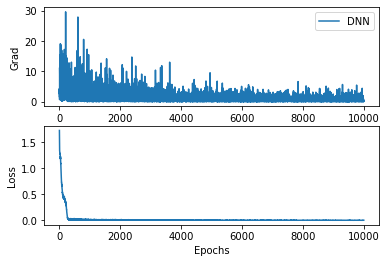

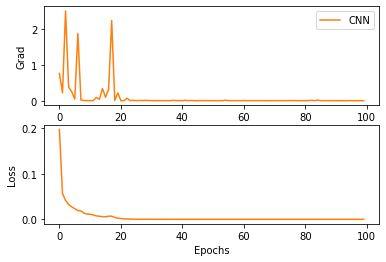

In [12]:
import matplotlib.pyplot as plt

## ---------------------------
## Plot loss and gradient norm
## ---------------------------

epochs = [DNN_epochs, CNN_epochs]
names = ['DNN', 'CNN']
colors = ['tab:blue', 'tab:orange']

for i in range(2):
  fig, axs = plt.subplots(2)
  axs[0].plot(np.arange(0, epochs[i]), overall_grad_norm[i], colors[i], label=names[i])
  axs[1].plot(np.arange(0, epochs[i]), overall_loss[i], colors[i])
  plt.xlabel('Epochs')
  axs[0].set(ylabel='Grad')
  axs[1].set(ylabel='Loss')
  axs[0].legend()
  plt.savefig(f'results/2/fig_gradient_norm_{names[i]}.pdf')
  plt.show()

### Part 3: What Happens When Gradient Is Almost Zero?

In [2]:
from torch.utils.data import DataLoader
from common.FunctionDataset import FunctionDataset

## -------------------------
## Prepare data for training
## -------------------------

num_data_points = 100
range_min = 0
range_max = 1

# prepare data loader for data of e^x * sin^2(3*pi*x) function 
raw_func_data = FunctionDataset(num_data_points, range_min, range_max)
training_data = raw_func_data.standardize()
training_loader = DataLoader(training_data, batch_size=1, shuffle=True)

print('Data ready.')

Data ready.


In [11]:
import torch.autograd as autograd

## ---------------------------
## Helper function definitions
## ---------------------------

# helper function to calculate the gradient normal (p-norm, p=2)
def calc_grad_norm(model):
    grad_all = 0.0

    for p in model.parameters():
        grad = 0.0 
        if p.grad is not None:
            grad = torch.sum(p.grad.cpu().data ** 2)
        grad_all += grad
    grad_norm = grad_all ** 0.5

    return grad_norm
    
# helper function to train model with quasi-Newton method & minimize grad norm
def train_zero_grad(model, data_loader):
    training_losses = []
    loss_with_grad_fn = []

    # https://pytorch.org/docs/stable/optim.html#torch.optim.LBFGS
    optimizer = optim.LBFGS(model.parameters(), lr=1e-7, max_iter=4)  
    loss_function = nn.MSELoss()

    for datum in data_loader:
        input, target = datum[0][0].reshape(-1), datum[0][1].reshape(-1)
        # calculates the gradient
        def closure():
            if torch.is_grad_enabled():
                optimizer.zero_grad()
            output = model(input)
            loss = loss_function(output, target)
            loss_with_grad_fn.append(loss)
            training_losses.append(loss.item())
            if loss.requires_grad:
                loss.backward(retain_graph=True)
            return loss
        optimizer.step(closure)

    return sum(training_losses)/len(training_losses), loss_with_grad_fn[-1]

# helper function to evaluate the Hessian matrix of a model
# based on: https://discuss.pytorch.org/t/compute-the-hessian-matrix-of-a-network/15270/3 
def eval_hessian(loss_grad, model):
    g_vector = torch.tensor([])
    # log/calculate first derivatives
    for g in loss_grad:
        g_vector = torch.cat([g_vector, g.contiguous().view(-1)])
    l = g_vector.size(0)
    hessian = torch.zeros(l, l)
    # calculate second derivatives
    for i in range(l):
        grad2nd = autograd.grad(g_vector[i], model.parameters(), create_graph=True)
        g2 = torch.tensor([])
        for g in grad2nd:
            g2 = torch.cat([g2, g.contiguous().view(-1)])
        hessian[i] = g2
    return hessian.data.numpy()

# helper function to calculate the minimal ratio of a model
def calc_min_ratio(model, loss):
    loss_grad = autograd.grad(loss, model.parameters(), create_graph=True, allow_unused=True)
    # compute the Hessian matrix
    H = eval_hessian(loss_grad, model)
    # get the eigenvalues of the Hessian
    e = np.linalg.eigvals(H)
    # find the proportion of nonzero eignvalues
    minimal_ratio = np.count_nonzero(e) / len(e)
    return minimal_ratio

In [13]:
import torch.nn as nn
import torch.optim as optim
from common.DNN_Models import ShallowNetwork

## -------------------------------
## Train model [est. time: 18 hrs] 
## -------------------------------

num_trainings = 100
loss_thresh = 1e-2
loss_diff_thresh = 1e-5
grad_norm_thresh = 1e-2

results = []
for i in range(num_trainings):
    model_loss = []
    prev_loss = 999.0
    loss = 99.0
    epoch = 0

    model = ShallowNetwork()
    model.zero_grad()
    
    # train until loss stops changing with default loss function
    print(f'[{i+1}] Training model')
    while abs(prev_loss - loss) > loss_diff_thresh or prev_loss > loss_thresh:
        prev_loss = loss
        loss = model.train(training_loader)
        model_loss.append(loss)
        epoch += 1
        
    # swap to minimizing grad norm with quasi-Newton method optimizer
    print('Minimizing grad norm')
    while calc_grad_norm(model) > grad_norm_thresh:
        loss_val, loss_with_grad_fn = train_zero_grad(model, training_loader)
        model_loss.append(loss_val)
        epoch += 1
    print(f'Minimized.\tGrad norm: {calc_grad_norm(model):.4f}\tLoss: {loss_val:.4f}')

    # compute minimal ratio
    minimal_ratio = calc_min_ratio(model, loss_with_grad_fn)
    results.append([minimal_ratio, loss])

# save results
np.savetxt('results/2/minimal_ratio_results.txt', np.array(results))

[1] Training model
Minimizing grad norm
Minimized.	Grad norm: 0.0077	Loss: 0.0064
[2] Training model
Minimizing grad norm
Minimized.	Grad norm: 0.0002	Loss: 0.0109
[3] Training model
Minimizing grad norm
Minimized.	Grad norm: 0.0004	Loss: 0.0131
[4] Training model
Minimizing grad norm
Minimized.	Grad norm: 0.0093	Loss: 0.0068
[5] Training model
Minimizing grad norm
Minimized.	Grad norm: 0.0045	Loss: 0.0067
[6] Training model
Minimizing grad norm
Minimized.	Grad norm: 0.0095	Loss: 0.0091
[7] Training model
Minimizing grad norm
Minimized.	Grad norm: 0.0002	Loss: 0.0124
[8] Training model
Minimizing grad norm
Minimized.	Grad norm: 0.0034	Loss: 0.0102
[9] Training model
Minimizing grad norm
Minimized.	Grad norm: 0.0049	Loss: 0.0062
[10] Training model
Minimizing grad norm
Minimized.	Grad norm: 0.0097	Loss: 0.0160
[11] Training model
Minimizing grad norm
Minimized.	Grad norm: 0.0063	Loss: 0.0065
[12] Training model
Minimizing grad norm
Minimized.	Grad norm: 0.0098	Loss: 0.0336
[13] Training

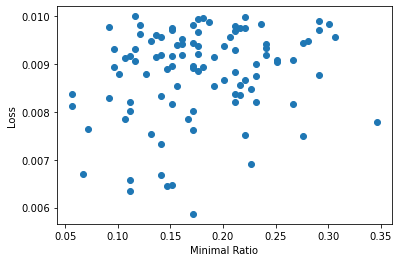

In [14]:
import matplotlib.pyplot as plt

## ------------
## Plot results
## ------------

# load results
mr_results = np.loadtxt('results/2/minimal_ratio_results.txt')

# plot minimal ratio vs loss
plt.plot(mr_results[:,0], mr_results[:,1], 'o')
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss')
plt.savefig(f'results/2/fig_minimal_ratio_loss.pdf')
plt.show()